In this notebook we will explore Data re-uploading.

Data re-uploading is a technique proposed in https://arxiv.org/abs/1907.02085.

The basic idea is that in classical neural networks, the input data is essentially "copied" and fed into the different neurons of the first hidden layer.
On a quantum computer however, the [no cloning theorem](https://de.wikipedia.org/wiki/No-Cloning-Theorem) prevents the copying of input data.

Therefore, the authors propose to re-upload the data with every layer of trainable parameters.

In their paper they then proof, that with this method, a single qubit is already able to perform classification of arbitrary functions and is therefore equivalent to a classical deep neural network with one hidden layer.

In this notebook we will explore data re-uploading with a simple example.

In [ ]:
!pip install pennylane --quiet

In [ ]:
import pennylane as qml
import pennylane.numpy as np
import matplotlib.pyplot as plt

## Data

As a toy example we want to classify 2d data arranged in a circle.
Lets first create our dataset.

In [ ]:
N = 1000
radius = 0.7

In [ ]:
X = np.random.uniform(low=-1, high=1, size=(N,2))
Y = np.sum(X**2, axis=1)**0.5 >= radius

In [ ]:
X_test = np.random.uniform(low=-1, high=1, size=(N,2))
Y_test = np.sum(X_test**2, axis=1)**0.5 >= radius

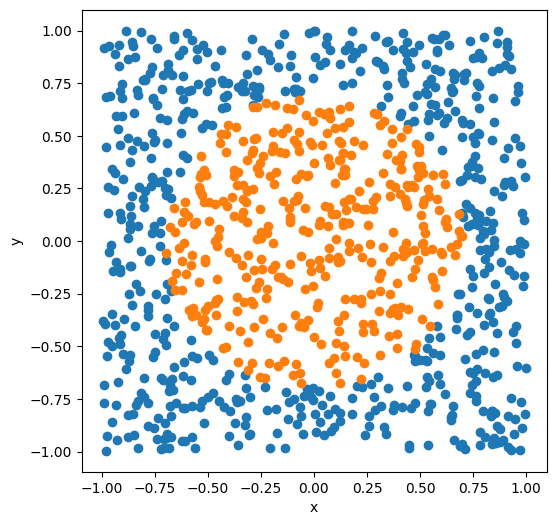

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(X[:,0][Y == True], X[:,1][Y == True])
plt.scatter(X[:,0][Y == False], X[:,1][Y == False])
plt.xlabel("x")
plt.ylabel("y");

As labels we will use $-1$ and $1$ for the different classes.

In [ ]:
x_train = X
y_train = 2*Y - 1

x_test = X_test
y_test = 2*Y_test - 1

## Data Re-uploading Circuit (DRC)

In [ ]:
dev = qml.device('lightning.qubit', wires=1)

As a single layer we use an arbitrary single qubit rotation $U(\vec{\phi})$, where the rotation angles $\phi$ are
$$\vec{\phi}=\vec{\Theta}+\vec{\omega}\circ\vec{x}$$.

Here the $\vec{\Theta}$ and $\vec{\omega}$ are the biases and weights respectively. The single qubit rotation $U$ takes three angles as arguments.
Since we only have two dimensional data, we will pad the third dimension with zeros (You could also simplify the circuit to save some gates if your feature space is not a multiple of three).

Note that this circuit can also be extendet to higher dimensional data by just appending more $U$s with the respecive features of the data.

In [ ]:
def layer(data, params):
    phi = data*params[:3]+params[3:6]
    qml.Rot(phi[0],phi[1],phi[2],wires=0)

The actual calssifier consinsts of a chosen number of reuploading layers and a Z measurement at the end.

In [ ]:
layers = 10

In [ ]:
@qml.qnode(dev)
def classifier(data, params):
    for i in range(layers):
        layer(data, params[i*6:(i+1)*6])
    return qml.expval(qml.PauliZ(0))

The final circuit looks rather simple!

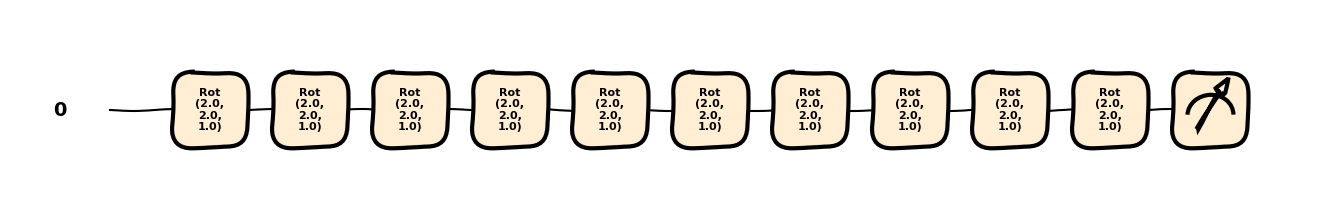

In [ ]:
qml.draw_mpl(classifier, decimals=1, style="sketch")([1,1,0],np.ones(layers*6))
plt.show()

## Training

Lets train the circuit similar to the QDNN example.
Since we used $-1$ and $1$ as labels we can use the [hinge loss](https://en.wikipedia.org/wiki/Hinge_loss) again.

In [ ]:
def loss(batch_x, batch_y, params):
  loss = 0
  for idx, x in enumerate(batch_x):
    y_pred = classifier(np.pad(x, (0,1)),params)
    loss += np.maximum(1 - batch_y[idx] * y_pred, 0)
  return loss / len(batch_x)

For training we define our parameters and
auxiliary methods like in the previous notebooks

In [ ]:
params = np.array(np.random.uniform(size=6*layers), requires_grad=True)*np.pi

In [ ]:
def iterate_minibatches(dataX, dataY, batch_size):
    for start_idx in range(0, dataX.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield dataX[idxs], dataY[idxs]

In [ ]:
def accuracy(dataX, dataY, params):
  acc = 0
  for idx, x in enumerate(dataX):
    pred = -1 if classifier(np.pad(x, (0,1)), params) < 0 else 1
    if pred == dataY[idx]: acc += 1
  return acc / len(dataX)

In [ ]:
epochs = 6
batch_size = 16
lr = 0.05

In [ ]:
opt = qml.AdamOptimizer(stepsize=lr)

Now we just loop over the batches of data to optimize

In [ ]:
import time
start = time.time()

for it in range(epochs):
    for j,data in enumerate(iterate_minibatches(x_train, y_train, batch_size=batch_size)):
        Xbatch, Ybatch = data
        cost_fn = lambda p: loss(Xbatch, Ybatch, p)
        params = opt.step(cost_fn, params)
        print(j, end="\r")

    loss_val = loss(x_train, y_train, params)
    acc = accuracy(x_train, y_train, params)

    print(f"Epoch: {it} | Loss: {loss_val:.3} | acc: {acc:.3} ")
    print("____")

end = time.time()

print(f"Time for {epochs} epochs: {end - start}")

Epoch: 0 | Loss: 0.368 | acc: 0.908 
____
Epoch: 1 | Loss: 0.365 | acc: 0.933 
____
Epoch: 2 | Loss: 0.353 | acc: 0.94 
____
Epoch: 3 | Loss: 0.344 | acc: 0.924 
____
Epoch: 4 | Loss: 0.342 | acc: 0.924 
____
Epoch: 5 | Loss: 0.341 | acc: 0.925 
____
Time for 6 epochs: 1564.2027921676636


As we can see, we already obtain a reasonable calssifying performance. Lets check the test data:

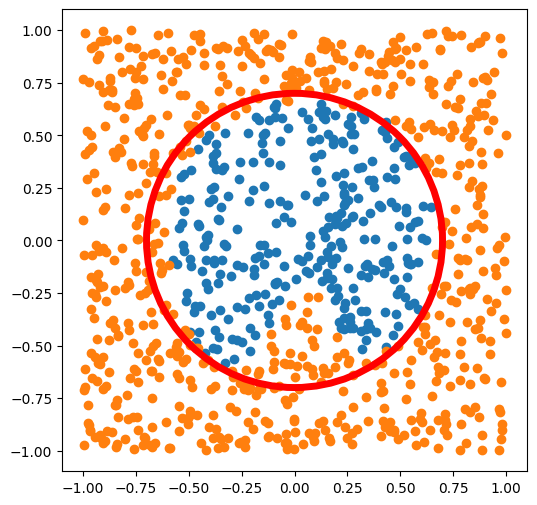

In [ ]:
plt.figure(figsize=(6,6))
class0 = x_test[np.array([classifier(np.pad(i, (0,1)),params) for i in x_test]) < 0]
class1 = x_test[np.array([classifier(np.pad(i, (0,1)),params) for i in x_test]) > 0]
plt.scatter(class0[:,0], class0[:,1])
plt.scatter(class1[:,0], class1[:,1])
circle1 = plt.Circle((0, 0), radius, color='r', fill=False, linewidth=5)
plt.gca().add_patch(circle1)

Try to experiment with the number of layers and see how it impacts the performance !

## Exercise: DRC for MNIST

We want to try to apply data re-uploading to a dataset with more than three features.

To do so use the MNIST dataset and reduce it with the PCA to four features.

Then build a data re-uploading calssifier for it (will have to use two Rot gates per layer and pad the data accordingly)